In [2]:
import h5py
import numpy as np
import skimage as sk
#print sk.__version__
from skimage import io
from matplotlib import pyplot as plt

### 数据标准化与保存

In [8]:
import os
import cv2
import h5py
import numpy as np
from scipy import ndimage
# 创建VOC目录结构
# 读取HDF5数据
with h5py.File(r'D:\桌面\毕业设计\dataset\LowRes_13434_overlapping_pairs.h5','r') as h5f:
    pairs = h5f['dataset_1'][:]

# 标签后处理（解决边缘噪声）
def refine_mask(raw_mask):
    mask = raw_mask.astype(np.uint8)
    cleaned = ndimage.binary_opening(mask, structure=np.ones((3,3)))
    labeled, num_features = ndimage.label(cleaned)
    if num_features == 0:
        return np.zeros_like(mask)
    sizes = ndimage.sum(cleaned, labeled, range(1, num_features+1))
    max_label = np.argmax(sizes) + 1
    return np.where(labeled == max_label, mask, 0)

In [9]:
# 定义调色板（需包含所有类别的颜色）
palette = [
    0,   0,   0,    # 0: 背景黑色（保留）
    0,   0, 255,    # 1: 红色（BGR顺序中的蓝色通道为255）
    255, 255, 0,    # 2: 青色（BGR中的黄色）
    255, 0, 0       # 3: 蓝色（BGR中的红色）
]

for idx in range(pairs.shape[0]):
    # 处理图像（保持不变）
    img = pairs[idx,...,0].astype(np.float32)
    img = (img / img.max() * 255).astype(np.uint8)
    cv2.imwrite(f'VOCdevkit/VOC2007/JPEGImages/{idx:05d}.jpg', img)

    # 处理标签（生成索引图）
    mask = refine_mask(pairs[idx,...,1])
    mask = np.clip(mask, 0, 3).astype(np.uint8)  # 确保mask值为0-3

    # 创建调色板图像（8位索引模式）
    from PIL import Image
    seg_pil = Image.fromarray(mask, mode='P')
    seg_pil.putpalette(palette)

    # 保存为8位PNG（PIL自动处理调色板）
    seg_pil.save(f'VOCdevkit/VOC2007/SegmentationClass/{idx:05d}.png')

In [10]:
# 修改后的6:2:2划分代码
indices = np.random.permutation(pairs.shape[0])
total_samples = len(indices)

# 计算分割点
split_train = int(0.6 * total_samples)
split_val = int(0.8 * total_samples)  # 60%+20%

# 生成文件路径
with open('VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt', 'w') as f:
    f.write('\n'.join([f"{i:05d}" for i in indices[:split_train]]))

with open('VOCdevkit/VOC2007/ImageSets/Segmentation/trainval.txt', 'w') as f:
    f.write('\n'.join([f"{i:05d}" for i in indices[split_train:split_val]]))

with open('VOCdevkit/VOC2007/ImageSets/Segmentation/test.txt', 'w') as f:
    f.write('\n'.join([f"{i:05d}" for i in indices[split_val:]]))

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# 生成标签（假设mask在pairs的第二通道）
labels = [np.any(pairs[i,:,:,1]) for i in range(pairs.shape[0])]

# 第一次分层抽样：60%训练集 + 40%临时集
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, temp_index in split1.split(pairs, labels):
    pass  # train_index是训练集索引，temp_index是剩余40%

# 第二次分层抽样：临时集再分50%验证+50%测试
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in split2.split(pairs[temp_index], np.array(labels)[temp_index]):
    pass  # val_index是验证集索引，test_index是测试集索引

# 组合最终索引
train_indices = train_index
val_indices = temp_index[val_index]
test_indices = temp_index[test_index]

# 验证比例
assert len(train_indices) + len(val_indices) + len(test_indices) == pairs.shape[0], "索引总数错误"
print(f"划分结果：训练集 {len(train_indices)}({len(train_indices)/pairs.shape[0]:.1%}) | "
      f"验证集 {len(val_indices)}({len(val_indices)/pairs.shape[0]:.1%}) | "
      f"测试集 {len(test_indices)}({len(test_indices)/pairs.shape[0]:.1%})")

划分结果：训练集 8060(60.0%) | 验证集 2687(20.0%) | 测试集 2687(20.0%)


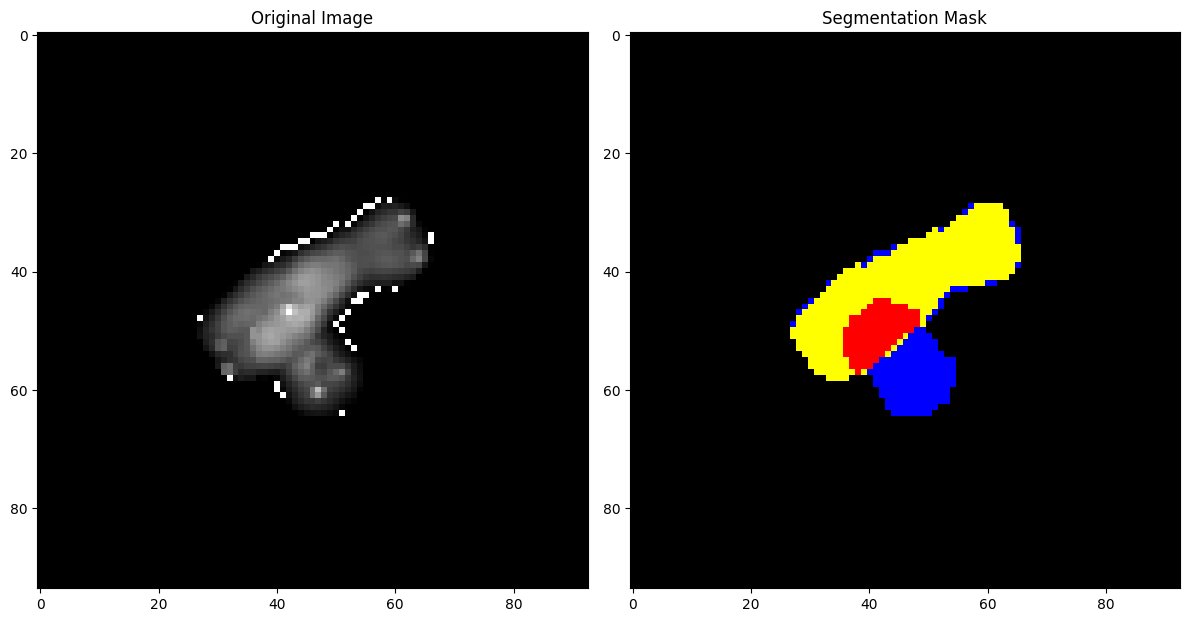

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

idx = 0
img_path = f'VOCdevkit/VOC2007/JPEGImages/{idx:05d}.png'
mask_path = f'VOCdevkit/VOC2007/SegmentationClass/{idx:05d}.png'

# 检查路径是否存在
if not (os.path.exists(img_path) and os.path.exists(mask_path)):
    print("文件路径错误！")
    exit()

# 读取图像并检查空值
img = cv2.imread(img_path, 0)  # 灰度模式
mask = cv2.imread(mask_path)
if img is None or mask is None:
    print("图像读取失败！")
    exit()

# 转换颜色空间（若mask为彩色）
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# 显示图像
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img, cmap='gray')  # 灰度图需指定cmap
plt.title('Original Image')

plt.subplot(122)
plt.imshow(mask_rgb)
plt.title('Segmentation Mask')

plt.tight_layout()
plt.show()

## Looking at some examples

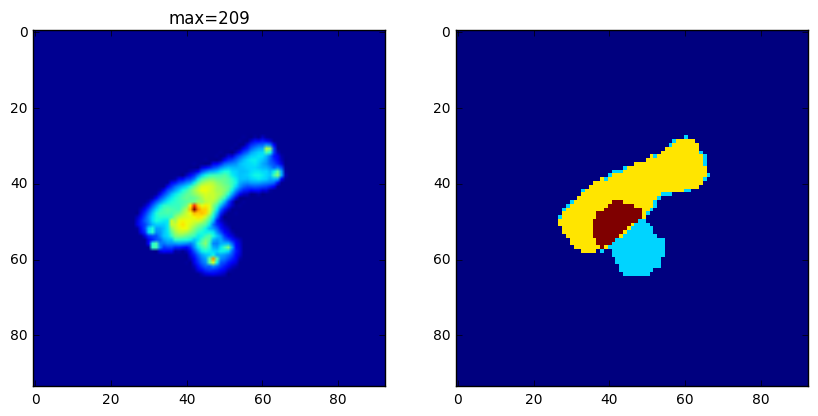

In [6]:
grey = pairs[0,:,:,0]
mask = pairs[0,:,:,1]
%matplotlib inline
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow(grey)
plt.title('max='+str(grey.max()))
plt.subplot(122)
plt.imshow(mask, interpolation = 'nearest')

### Problem in the groundtruth label at low resolution:

The labels are a little noisy on the edge of the groundtruth label.

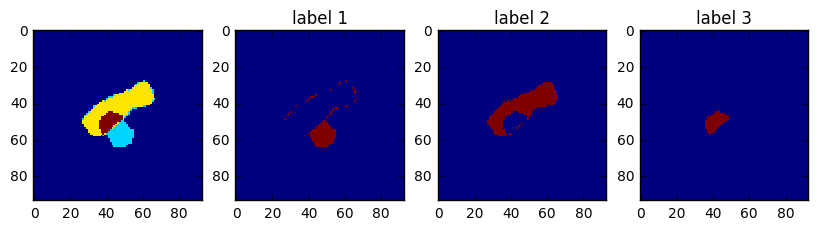

In [7]:
plt.figure(figsize = (10,12))
plt.subplot(141)
plt.imshow(mask, interpolation = 'nearest')
plt.subplot(142)
plt.title('label 1')
plt.imshow(mask == 1, interpolation = 'nearest')
plt.subplot(143)
plt.title('label 2')
plt.imshow(mask == 2, interpolation = 'nearest')
plt.subplot(144)
plt.title('label 3')
plt.imshow(mask == 3,  interpolation = 'nearest')